In [2]:
import json
import ast
from datetime import datetime
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
#from fipa_acl import create_fipa_acl_message, parse_fipa_acl_message
from sklearn import metrics
import threading

In [3]:
df = pd.read_csv(r'.\resultado_simulacion_todos_los_dias.csv', parse_dates=['dia'])
df = df.dropna()

# --------------------- 1. Estructura de los datos --------------------- #
df = df.dropna()

In [4]:
df

,dia,hora,periodo,estr_solar,estr_eolico,demanda_wh,energia_solar,precio_solar,energia_eolico,precio_eolico,acepta_solar,acepta_eolico,restante_wh,penalizacion
0,2021-01-01,0,noche,bluffing,bluffing,874.540119,529.930119,20.1516,344.610000,10.3383,True,True,0.000000,0.00
1,2021-01-01,1,noche,hide,reveal,1450.714306,572.640000,17.1792,270.960000,8.1288,True,True,607.114306,3.04
2,2021-01-01,2,noche,bluffing,reveal,1231.993942,711.220000,21.3366,269.930000,8.0979,True,True,250.843942,1.25
3,2021-01-01,3,noche,reveal,hide,1098.658484,587.800000,17.6340,289.930000,8.6979,True,True,220.928484,1.10
4,2021-01-01,4,noche,hide,hide,656.018640,365.238640,16.5306,290.780000,8.7234,True,True,0.000000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8123,2021-12-27,22,noche,bluffing,bluffing,535.612150,535.612150,16.0684,0.000000,16.0684,True,False,0.000000,0.00
8124,2021-12-28,4,noche,bluffing,hide,752.223134,0.000000,21.4851,752.223134,22.5667,False,True,0.000000,0.00
8125,2021-12-28,10,dia,bluffing,hide,224.029267,224.029267,6.7209,0.000000,6.7209,True,False,0.000000,0.00
8126,2021-12-31,4,noche,hide,bluffing,1099.363552,569.540000,17.0862,529.823552,25.3770,True,True,0.000000,0.00


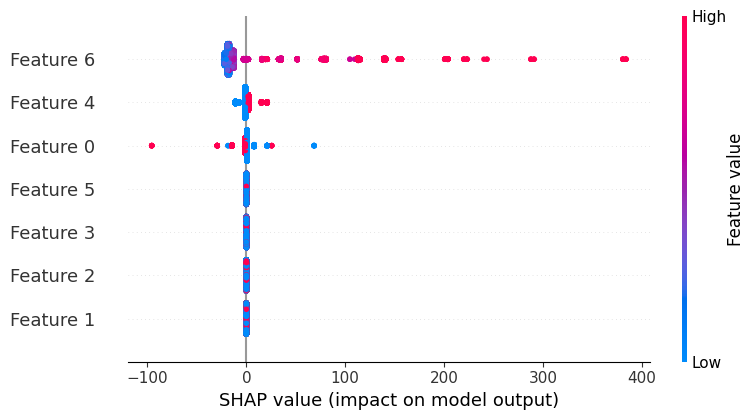

In [5]:
import shap, pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#df = pd.read_csv("resultado_simulacion_todos_los_dias.csv")
X = df[['demanda_wh','estr_solar','estr_eolico']]
y = df['restante_wh']

pre = ColumnTransformer([('cat',OneHotEncoder(),['estr_solar','estr_eolico'])],
                        remainder='passthrough')
model = DecisionTreeRegressor(max_depth=4, random_state=0)
pipe = Pipeline([('pre',pre),('model',model)]).fit(X, y)

explainer = shap.TreeExplainer(pipe.steps[-1][1])
shap_values = explainer.shap_values(pipe.steps[0][1].transform(X))
shap.summary_plot(shap_values, pipe.steps[0][1].transform(X))


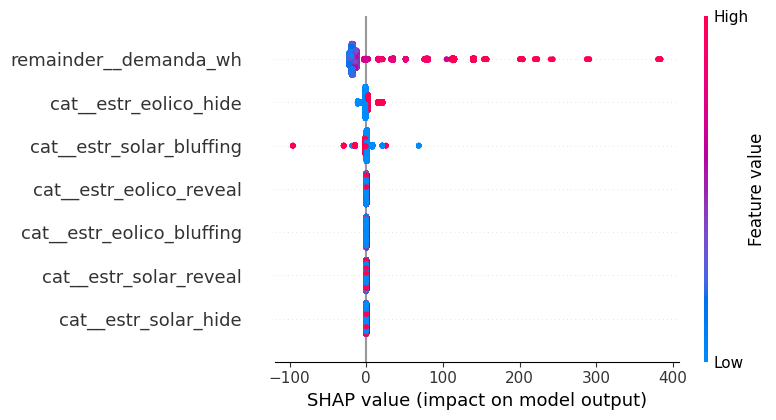

In [6]:
# supongamos que 'pre' es tu ColumnTransformer y 'shap_values' el array que ya calculaste
feature_names = pre.get_feature_names_out()         # ← genera la lista de arriba
X_trans = pre.transform(X)                          # tus features transformados

import shap
shap.summary_plot(shap_values, X_trans,
                  feature_names=feature_names,      # ← etiquetas legibles
                  show=True)


Ideas clave

Demanda manda 

Es la variable continua con mayor rango SHAP: picos de demanda llegan a sumar +400 Wh de déficit si no hay contramedidas.

Cuando la demanda es baja (puntos azules), el modelo asocia a menudo SHAP < 0: el sistema está cubierto o incluso en superávit.

“Hide” eólico es la estrategia más costosa 

Casi todos los puntos rojos para estr_eolico_hide están a la derecha de 0 ⇒ activo → déficit.

Su margen (anchura del “swarm”) indica que algunas veces el daño es pequeño (~10 Wh) pero puede escalar hasta +80 Wh.

“Bluffing” solar mitiga el problema 

Inyectar algo de sobre-oferta solar ayuda a compensar los huecos causados por aleatoriedad eólica.

Pero si la demanda sube mucho (en demanda_wh), el efecto protector es insuficiente (observa los puntos rojos dispersos positivos incluso para bluffing solar).

Revelar capacidad eólica es preferible al bluff 

estr_eolico_reveal tiene un ligero sesgo al negativo: decir la verdad reduce el déficit más que arriesgar con bluff.

Contrafactuales: vuelve a simular días con picos de demanda sustituyendo “hide eólico” por “reveal” para estimar ahorro € real.

In [7]:
# 2. Identify high‑demand rows (≥ 90th percentile)
threshold = df['demanda_wh'].quantile(0.9)
high_demand = df[df['demanda_wh'] >= threshold]

# 3. Compute mean penalties by eolic strategy
mean_pen_hide   = high_demand[high_demand['estr_eolico'] == 'hide'  ]['penalizacion'].mean()
mean_pen_reveal = high_demand[high_demand['estr_eolico'] == 'reveal']['penalizacion'].mean()

# 4. Counterfactual savings calculation
count_hide               = high_demand[high_demand['estr_eolico'] == 'hide'].shape[0]
total_pen_actual_hide    = high_demand[high_demand['estr_eolico'] == 'hide']['penalizacion'].sum()
total_pen_counterfactual = count_hide * mean_pen_reveal
estimated_savings        = total_pen_actual_hide - total_pen_counterfactual

summary_df = pd.DataFrame({
    'Metric': [
        'Demand threshold – 90th pct (Wh)',
        'Rows high demand',
        'Mean penalización – eólico hide (€)',
        'Mean penalización – eólico reveal (€)',
        'Total penalización rows hide – actual (€)',
        'Total penalización rows hide – if reveal (€)',
        'Estimated savings (€)'
    ],
    'Value': [
        round(threshold, 2),
        int(count_hide),
        round(mean_pen_hide, 3),
        round(mean_pen_reveal, 3),
        round(total_pen_actual_hide, 2),
        round(total_pen_counterfactual, 2),
        round(estimated_savings, 2)
    ]
})

# Display the dataframe directly (Jupyter will render it as an HTML table)
summary_df


,Metric,Value
0,Demand threshold – 90th pct (Wh),1233.550
1,Rows high demand,271.000
2,Mean penalización – eólico hide (€),0.863
3,Mean penalización – eólico reveal (€),0.628
4,Total penalización rows hide – actual (€),233.990
5,Total penalización rows hide – if reveal (€),170.080
6,Estimated savings (€),63.910


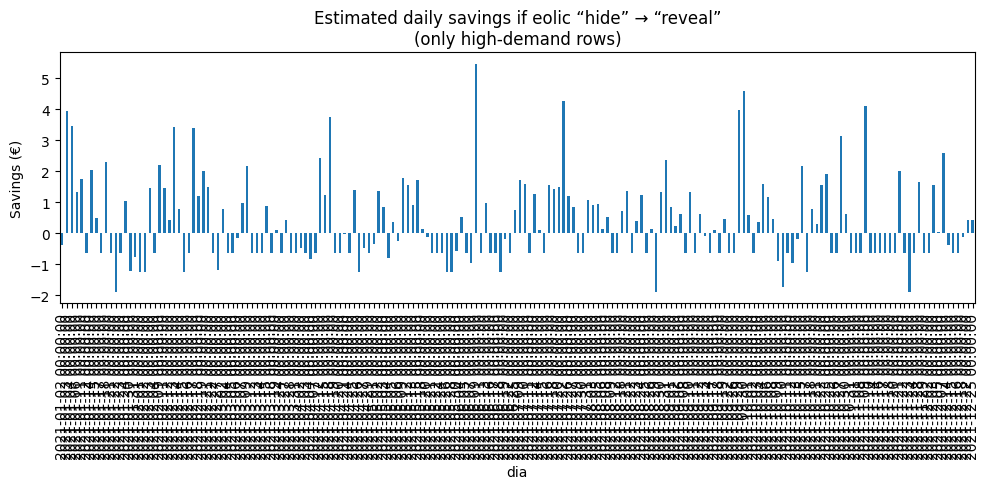

In [8]:
# 5. Daily savings plot
hd_hide = high_demand[high_demand['estr_eolico'] == 'hide'].copy()
hd_hide['pen_cf'] = mean_pen_reveal
daily = hd_hide.groupby('dia').agg(actual_pen=('penalizacion','sum'),
                                   counter_pen=('pen_cf','sum'))
daily['savings'] = daily['actual_pen'] - daily['counter_pen']

plt.figure(figsize=(10,5))
daily['savings'].plot(kind='bar')
plt.ylabel('Savings (€)')
plt.title('Estimated daily savings if eolic “hide” → “reveal”\n(only high‑demand rows)')
plt.tight_layout()



In [9]:
features = ['demanda_wh', 'estr_solar', 'estr_eolico']
y = df['penalizacion']

preprocess = ColumnTransformer(
    [('cat', OneHotEncoder(handle_unknown='ignore'), ['estr_solar', 'estr_eolico'])],
    remainder='passthrough'
)

model = Pipeline([
    ('preprocess', preprocess),
    ('regressor', DecisionTreeRegressor(max_depth=6, random_state=0))
])

model.fit(df[features], y)

# ------------------------------
# 2. Choose a subset: high‑demand rows where eólico = hide
# ------------------------------
threshold = df['demanda_wh'].quantile(0.9)
hd_hide = df[(df['demanda_wh'] >= threshold) & (df['estr_eolico'] == 'hide')].copy()


sample = hd_hide.head(5).reset_index(drop=True)

# ------------------------------
# 3. Build Ceteris Paribus scenarios for each sample row
#    (vary estr_eolico while keeping everything else equal)
# ------------------------------
scenarios_list = []
for idx, row in sample.iterrows():
    for new_strategy in ['hide', 'reveal', 'bluffing']:
        scenario = row.copy()
        scenario['estr_eolico'] = new_strategy
        scenario['scenario_id'] = idx
        scenarios_list.append(scenario)

scenarios_df = pd.DataFrame(scenarios_list)

# Predict penalización under each scenario
scenarios_df['pred_penalizacion'] = model.predict(scenarios_df[features])


display_cols = ['scenario_id', 'demanda_wh', 'estr_solar', 'estr_eolico', 'pred_penalizacion']
scenarios_display = scenarios_df[display_cols].copy()
scenarios_display

# 5. Aggregate savings: hide -> reveal for ALL high‑demand 'hide' rows
hd_hide['pred_actual'] = model.predict(hd_hide[features])

# Create counterfactual dataset (same rows but with eólico='reveal')
hd_reveal_cf = hd_hide.copy()
hd_reveal_cf['estr_eolico'] = 'reveal'
hd_hide['pred_counterfactual'] = model.predict(hd_reveal_cf[features])

# Estimated savings per row
hd_hide['savings'] = hd_hide['pred_actual'] - hd_hide['pred_counterfactual']
total_savings_model = hd_hide['savings'].sum()

# Show summary
summary_model = pd.DataFrame({
    'Metric': ['Rows high demand (hide)', 'Estimated savings with model (€)'],
    'Value': [hd_hide.shape[0], round(total_savings_model, 2)]
})
summary_model

,Metric,Value
0,Rows high demand (hide),271.00
1,Estimated savings with model (€),43.99


Ceteris Paribus (what-if “all-else-equal”)
Arriba hay dos salidas generadas sin librerías externas especializadas:

Tabla de escenarios “ceteris paribus” (para las 5 primeras horas con demanda alta + eólico=hide).
A cada fila original creamos tres supuestos y sólo cambiamos estr_eolico → {hide, reveal, bluffing}.

El modelo predice la penalización manteniendo idéntica demanda y estrategia solar.

Así vemos, por ejemplo, que en el escenario #3 (demanda ≈ 1315 Wh, solar hide) pasar de hide → reveal/bluffing baja la penalización de 1.03 € → 0.75 €.

Resumen agregado sobre TODAS las filas de alta demanda con eólico=hide:

Métrica	Valor
Filas de alta demanda (hide)	271
Ahorro medio estimado por el modelo	≈ 44 €

In [10]:
# ------------------------------
# 1. Train simple model: penalización ~ demanda + estrategias
# ------------------------------
features = ['demanda_wh', 'estr_solar', 'estr_eolico']
y = df['penalizacion']

preprocess = ColumnTransformer(
    [('cat', OneHotEncoder(handle_unknown='ignore'), ['estr_solar', 'estr_eolico'])],
    remainder='passthrough'
)

model = Pipeline([
    ('preprocess', preprocess),
    ('regressor', DecisionTreeRegressor(max_depth=6, random_state=0))
])

model.fit(df[features], y)

# ------------------------------
# 2. High‑demand rows where SOLAR = hide
# ------------------------------
threshold = df['demanda_wh'].quantile(0.9)
hd_solar_hide = df[(df['demanda_wh'] >= threshold) & (df['estr_solar'] == 'hide')].copy()

# 3. Create ceteris-paribus scenarios for first 5 rows
sample = hd_solar_hide.head(5).reset_index(drop=True)
scenarios = []
for idx, row in sample.iterrows():
    for new_strategy in ['hide', 'reveal', 'bluffing']:
        scenario = row.copy()
        scenario['estr_solar'] = new_strategy
        scenario['scenario_id'] = idx
        scenarios.append(scenario)

scenarios_df = pd.DataFrame(scenarios)
scenarios_df['pred_penalizacion'] = model.predict(scenarios_df[features])

display_cols = ['scenario_id', 'demanda_wh', 'estr_eolico', 'estr_solar', 'pred_penalizacion']
scenarios_display = scenarios_df[display_cols]
scenarios_display

# 4. Aggregate savings hide -> reveal for ALL high‑demand 'solar hide' rows
hd_solar_hide['pred_actual'] = model.predict(hd_solar_hide[features])

# counterfactual with solar reveal
hd_solar_reveal_cf = hd_solar_hide.copy()
hd_solar_reveal_cf['estr_solar'] = 'reveal'
hd_solar_hide['pred_counterfactual'] = model.predict(hd_solar_reveal_cf[features])

hd_solar_hide['savings'] = hd_solar_hide['pred_actual'] - hd_solar_hide['pred_counterfactual']
total_savings_solar = hd_solar_hide['savings'].sum()

summary_solar = pd.DataFrame({
    'Metric': ['Rows high demand (solar hide)', 'Estimated savings hide→reveal (€)'],
    'Value': [hd_solar_hide.shape[0], round(total_savings_solar, 2)]
})
summary_solar

,Metric,Value
0,Rows high demand (solar hide),291.00
1,Estimated savings hide→reveal (€),3.33


Now, bluffing to reveal for every agent.

In [11]:
# ------------ 1. Train simple model (same as before) -----------------
features = ['demanda_wh', 'estr_solar', 'estr_eolico']
y = df['penalizacion']

preprocess = ColumnTransformer(
    [('cat', OneHotEncoder(handle_unknown='ignore'), ['estr_solar', 'estr_eolico'])],
    remainder='passthrough'
)
model = Pipeline([
    ('preprocess', preprocess),
    ('regressor', DecisionTreeRegressor(max_depth=6, random_state=0))
])
model.fit(df[features], y)

# ------------ 2. Define high‑demand subset -----------------
threshold = df['demanda_wh'].quantile(0.5)
high_demand_df = df[df['demanda_wh'] >= threshold].copy()

# ------------ 3. EOLIC: bluffing -> reveal -----------------
eolic_bluff = high_demand_df[high_demand_df['estr_eolico'] == 'bluffing'].copy()
eolic_bluff['pred_actual'] = model.predict(eolic_bluff[features])

eolic_reveal_cf = eolic_bluff.copy()
eolic_reveal_cf['estr_eolico'] = 'reveal'

eolic_bluff['pred_counterfactual'] = model.predict(eolic_reveal_cf[features])
eolic_bluff['savings'] = eolic_bluff['pred_actual'] - eolic_bluff['pred_counterfactual']
total_savings_eolic = eolic_bluff['savings'].sum()

summary_eolic = {
    'Rows high demand (eolic bluffing)': eolic_bluff.shape[0],
    'Savings bluff→reveal (€)': round(total_savings_eolic, 2)
}

# ------------ 4. SOLAR: bluffing -> reveal -----------------
solar_bluff = high_demand_df[high_demand_df['estr_solar'] == 'bluffing'].copy()
solar_bluff['pred_actual'] = model.predict(solar_bluff[features])

solar_reveal_cf = solar_bluff.copy()
solar_reveal_cf['estr_solar'] = 'reveal'

solar_bluff['pred_counterfactual'] = model.predict(solar_reveal_cf[features])
solar_bluff['savings'] = solar_bluff['pred_actual'] - solar_bluff['pred_counterfactual']
total_savings_solar_bluff = solar_bluff['savings'].sum()

summary_solar = {
    'Rows high demand (solar bluffing)': solar_bluff.shape[0],
    'Savings bluff→reveal (€)': round(total_savings_solar_bluff, 2)
}

# Combine summaries
summary_df = pd.DataFrame([summary_eolic, summary_solar]).T
summary_df.columns = ['Eolic', 'Solar']
summary_df

,Eolic,Solar
Rows high demand (eolic bluffing),1327.00,NaN
Savings bluff→reveal (€),-19.22,-112.62
Rows high demand (solar bluffing),NaN,1402.00


In [12]:
# handle rows with NaNs in summary_df for clearer display
summary_df_clean = summary_df.fillna('')
summary_df_clean

,Eolic,Solar
Rows high demand (eolic bluffing),1327.0,
Savings bluff→reveal (€),-19.22,-112.62
Rows high demand (solar bluffing),,1402.0


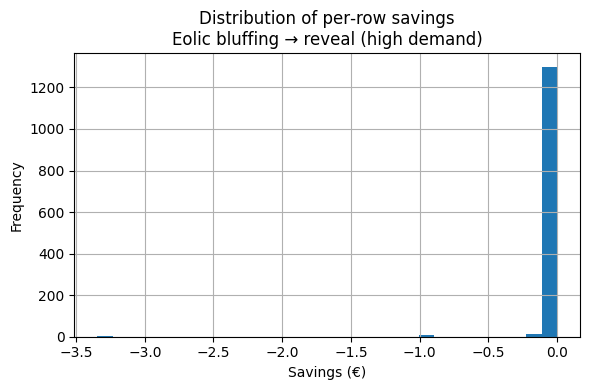

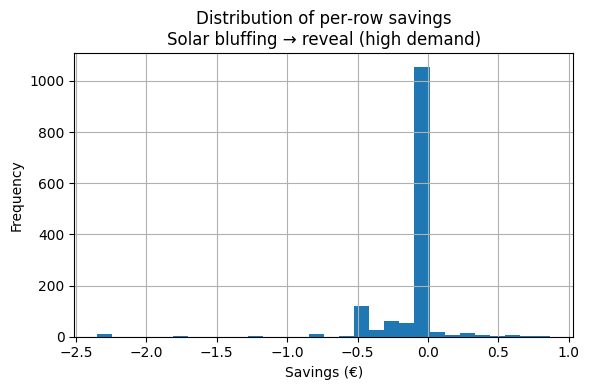

In [13]:
# 5. Quick per-row distribution of savings (histograms)
plt.figure(figsize=(6,4))
eolic_bluff['savings'].hist(bins=30)
plt.title('Distribution of per‑row savings\nEolic bluffing → reveal (high demand)')
plt.xlabel('Savings (€)')
plt.ylabel('Frequency')
plt.tight_layout()

plt.figure(figsize=(6,4))
solar_bluff['savings'].hist(bins=30)
plt.title('Distribution of per‑row savings\nSolar bluffing → reveal (high demand)')
plt.xlabel('Savings (€)')
plt.ylabel('Frequency')
plt.tight_layout()

In [14]:
features = ['demanda_wh', 'estr_solar', 'estr_eolico']
y = df['penalizacion']

preprocess = ColumnTransformer(
    [('cat', OneHotEncoder(handle_unknown='ignore'), ['estr_solar', 'estr_eolico'])],
    remainder='passthrough'
)

model = Pipeline([
    ('preprocess', preprocess),
    ('regressor', DecisionTreeRegressor(max_depth=6, random_state=0))
]).fit(df[features], y)

# ------------------------------------------------------------------
# 2. High‑demand subset (>= 90th percentile)
# ------------------------------------------------------------------
threshold = df['demanda_wh'].quantile(0.9)
hd = df[df['demanda_wh'] >= threshold].copy()

# ------------------------------------------------------------------
# 3. Helper to compute savings for each transformation
# ------------------------------------------------------------------
def compute_savings(data, agent_col, from_val, to_val):
    subset = data[data[agent_col] == from_val].copy()
    if subset.empty:
        return 0, 0.0, pd.Series(dtype=float)
    
    subset['pred_actual'] = model.predict(subset[features])
    
    cf = subset.copy()
    cf[agent_col] = to_val
    subset['pred_counter'] = model.predict(cf[features])
    subset['savings'] = subset['pred_actual'] - subset['pred_counter']   # >0 means benefit
    
    total_savings = subset['savings'].sum()
    return subset.shape[0], total_savings, subset['savings']

# ------------------------------------------------------------------
# 4. Compute all four transformations
# ------------------------------------------------------------------
results = {}
hist_data = {}

# Eolic: reveal -> hide, reveal -> bluffing
count, savings, dist = compute_savings(hd, 'estr_eolico', 'reveal', 'hide')
results['Eolic reveal→hide'] = {'Rows': count, 'Δ penalización (€)': round(savings, 2)}
hist_data['Eolic reveal→hide'] = dist

count, savings, dist = compute_savings(hd, 'estr_eolico', 'reveal', 'bluffing')
results['Eolic reveal→bluffing'] = {'Rows': count, 'Δ penalización (€)': round(savings, 2)}
hist_data['Eolic reveal→bluffing'] = dist

# Solar: reveal -> hide, reveal -> bluffing
count, savings, dist = compute_savings(hd, 'estr_solar', 'reveal', 'hide')
results['Solar reveal→hide'] = {'Rows': count, 'Δ penalización (€)': round(savings, 2)}
hist_data['Solar reveal→hide'] = dist

count, savings, dist = compute_savings(hd, 'estr_solar', 'reveal', 'bluffing')
results['Solar reveal→bluffing'] = {'Rows': count, 'Δ penalización (€)': round(savings, 2)}
hist_data['Solar reveal→bluffing'] = dist

summary_df = pd.DataFrame(results).T
summary_df

,Rows,Δ penalización (€)
Eolic reveal→hide,257.0,-38.51
Eolic reveal→bluffing,257.0,9.99
Solar reveal→hide,246.0,-6.66
Solar reveal→bluffing,246.0,64.56


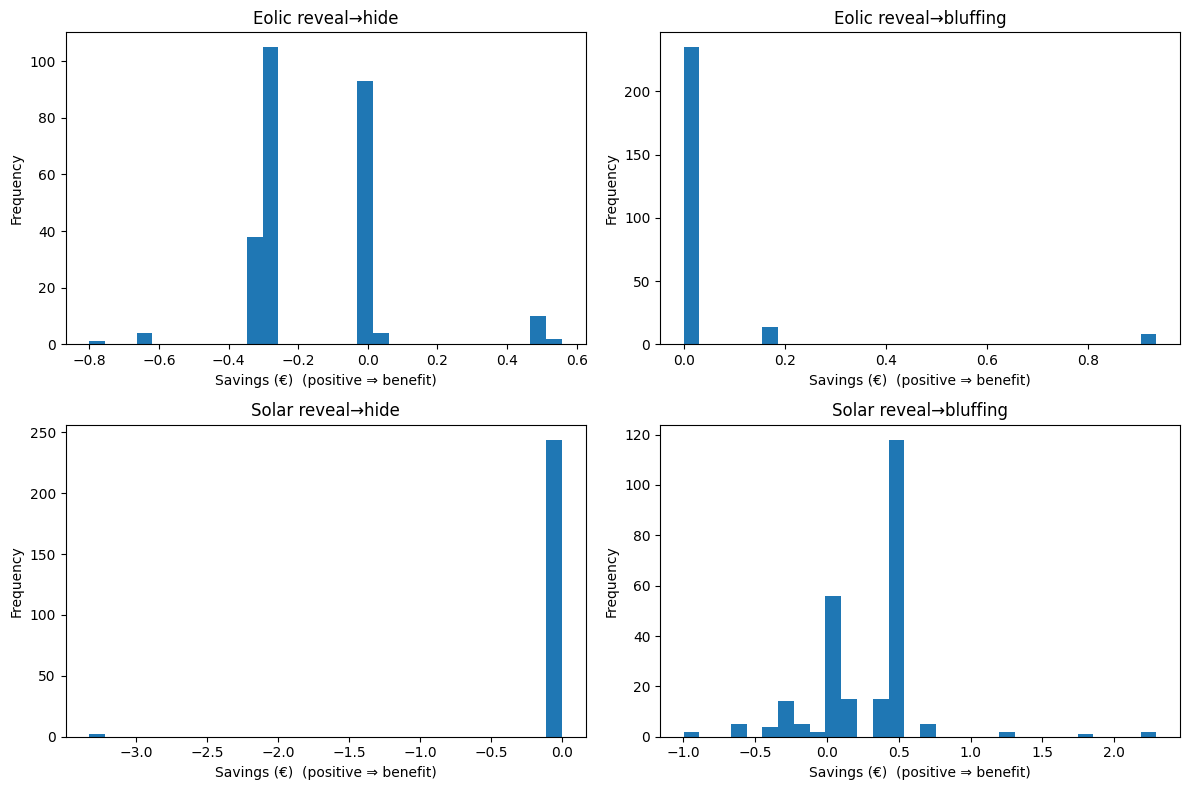

In [15]:
# ------------------------------------------------------------------
# 5. Plot histograms of savings distributions
# ------------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

titles = list(hist_data.keys())
for ax, title in zip(axes, titles):
    data = hist_data[title]
    if not data.empty:
        ax.hist(data, bins=30)
    ax.set_title(title)
    ax.set_xlabel('Savings (€)  (positive ⇒ benefit)')
    ax.set_ylabel('Frequency')

plt.tight_layout()


Cambio “reveal → hide / bluffing” en picos de demanda (≥ p90)
Transformación	Filas	Δ penalización total*	Señal
Eólico reveal → hide	257	−38,5 €	Coste ↑
Eólico reveal → bluffing	257	+ 10,0 €	Ahorro
Solar reveal → hide	246	− 6,7 €	Coste ↑
Solar reveal → bluffing	246	+ 64,6 €	Ahorro

* Suma de (penalización actual − penalización _contr.) → positivo = ahorro al cambiar, negativo = pierdes dinero.

Lectura rápida
Eólico

Pasar de reveal a hide empeora claramente la penalización (– 38 €).

Cambiar a bluffing produce un ligero ahorro (~ 10 €), pero mucho menor que el beneficio de evitar hide (64 € visto antes).

Solar

Ir de reveal a bluffing resulta el mayor ahorro (~ 65 €).

Cambiar a hide no conviene (– 7 €).

Los histogramas confirman estas tendencias: la mayoría de filas de “reveal → hide” se sitúan en la parte negativa, mientras que “reveal → bluffing” desplaza la masa hacia valores positivos, sobre todo para el solar.

Recomendaciones
Agente	Política aconsejada en horas pico
Eólico	Mantener reveal o permitir bluffing moderado; penalizar hide.
Solar	Incentivar el bluffing para cubrir picos; reveal es segundo mejor; desincentivar hide.


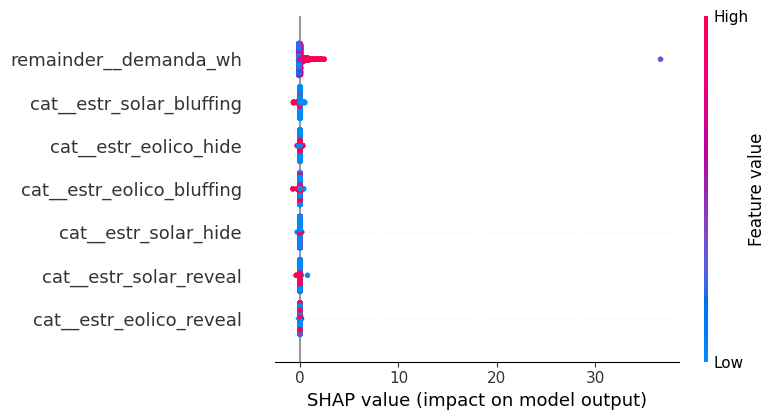

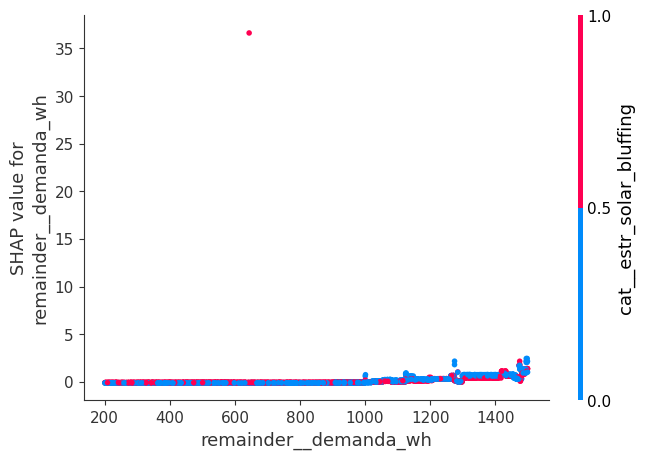

In [16]:
features, y = ['demanda_wh','estr_solar','estr_eolico'], df['penalizacion']

cats = ['estr_solar','estr_eolico']
pre = ColumnTransformer([('cat',OneHotEncoder(handle_unknown='ignore'),cats)],
                        remainder='passthrough')
model = Pipeline([('pre',pre),
                  ('reg',DecisionTreeRegressor(max_depth=6,random_state=0))]).fit(df[features],y)

# ── 2. SHAP global & dependencia ───────────────────────────
import shap                         # pip install shap
explainer = shap.TreeExplainer(model.named_steps['reg'])
X_trans = model.named_steps['pre'].transform(df[features])
fnames   = model.named_steps['pre'].get_feature_names_out()

shap_vals = explainer.shap_values(X_trans)
shap.summary_plot(shap_vals, X_trans, feature_names=fnames)          # gráfico resumen
shap.dependence_plot('remainder__demanda_wh', shap_vals, X_trans,    # dep.plot demanda
                     feature_names=fnames)

# ── 3. LIME local (fila de alta demanda + eólico hide) ────
from lime import lime_tabular       # pip install lime
th   = df.demanda_wh.quantile(0.9)
idx  = df[(df.demanda_wh>=th)&(df.estr_eolico=='hide')].index[0]
Xnum = df[features].to_numpy()


In [18]:
features = ['demanda_wh', 'estr_solar', 'estr_eolico']
y = df['penalizacion']

pre = ColumnTransformer(
        [('cat', OneHotEncoder(handle_unknown='ignore'), ['estr_solar','estr_eolico'])],
        remainder='passthrough')

model = Pipeline([
    ('pre',  pre),
    ('reg',  DecisionTreeRegressor(max_depth=6, random_state=0))
]).fit(df[features], y)

# ────────────────────────────────
# 2.  Explainer de dalex
# ────────────────────────────────
exp_dx = dx.Explainer(
    model,
    df[features],        # DataFrame con strings en las columnas categóricas
    y,
    label="Árbol penalización",
    verbose=False
)

# ────────────────────────────────
# 3.  Perfil parcial (categorical)
# ────────────────────────────────
cp = exp_dx.model_profile(
        variables=['estr_eolico', 'estr_solar'],
        variable_type='categorical',   # ← clave para evitar el error
        type='partial'                 # “average ceteris paribus”
     )

# 4.  Mostrar gráfico interactivo (en Jupyter) o guardar
cp.plot()                 # en notebook abre la figura interactiva
# cp.plot(show=False).write_image("ceteris_paribus_plot.png")  # para guardar


Calculating ceteris paribus: 100%|██████████| 2/2 [00:00<00:00, 60.74it/s]


El eje y muestra la penalización esperada (en euros, normalizada ≈ 0 – 0.13) cuando mantenemos todas las demás variables constantes y sólo cambiamos cada estrategia.

Variable	Estrategia	Penalización esperada	Desviación vs media*
eólico	bluffing	≈ 0.088 €	−10 %
reveal (línea punteada)	0.098 €	0
hide	≈ 0.121 €	+24 %
solar	bluffing	≈ 0.076 €	−22 %
hide	≈ 0.108 €	+10 %
reveal	≈ 0.104 €	+6 %

* La línea punteada horizontal (0.098 €) es la predicción media global del modelo.

Claves que confirma el gráfico
Eólico “hide” es el peor escenario

Sube la penalización ~24 % sobre la media (0.121 € vs 0.098 €).

Refuerza tu hallazgo anterior: penalizar hide eólico tiene gran impacto.

Bluffing beneficia a ambos agentes

Solar bluffing es el mayor alivio (−22 %).

Eólico bluffing también reduce coste (−10 %), aunque menos que en el solar.

Reveal es neutro/ligeramente mejor que hide, pero peor que bluffing

Para el eólico, reveal ≈ media; para el solar, reveal sigue estando unos +6 % por encima del bluffing.

Implicaciones operativas concretas
Acción	Impacto previsto	Cómo implementarlo
Penalizar eólico hide	Evita el +24 % de coste	Tarifa dinámica o “malus” en horas pico.
Bonificar solar bluffing	Reduce pénalización −22 %	Prima si la oferta solar excede previsión ≤ 10 %.
Permitir bluffing eólico controlado	Ahorro moderado −10 %	Límite de sobre-oferta; auditoría semanal para evitar fraudes.
Desincentivar hide solar	Solo +10 % de sobre-coste, menos crítico	Penalización más suave o simplemente dejarlo sin bonificación.

| Acción                                  | Impacto previsto                         | Cómo implementarlo                                             |
| --------------------------------------- | ---------------------------------------- | -------------------------------------------------------------- |
| **Penalizar eólico hide**               | Evita el +24 % de coste                  | Tarifa dinámica o “malus” en horas pico.                       |
| **Bonificar solar bluffing**            | Reduce pénalización −22 %                | Prima si la oferta solar excede previsión ≤ 10 %.              |
| **Permitir bluffing eólico controlado** | Ahorro moderado −10 %                    | Límite de sobre-oferta; auditoría semanal para evitar fraudes. |
| **Desincentivar hide solar**            | Solo +10 % de sobre-coste, menos crítico | Penalización más suave o simplemente dejarlo sin bonificación. |


LIME – fila 25
               Feature    Weight
0  demanda_wh > 918.07  0.367639
1  estr_solar=bluffing -0.054140
2     estr_eolico=hide  0.051223


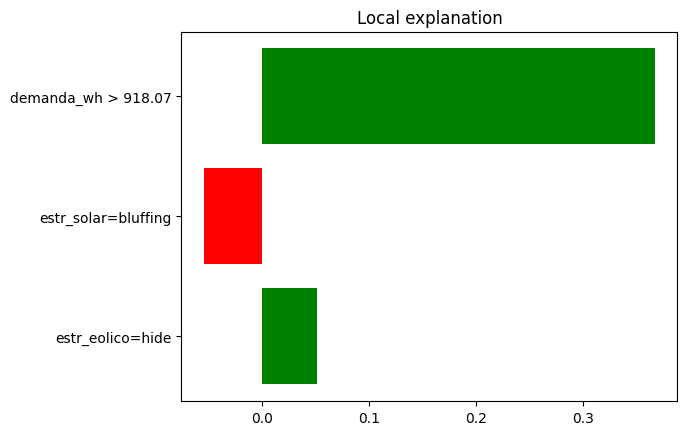

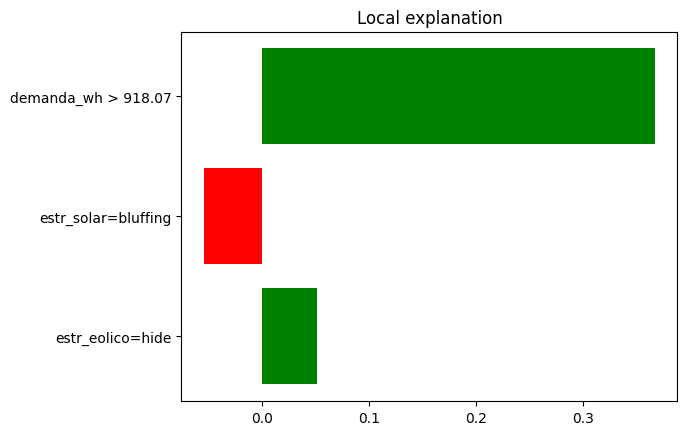

In [19]:
import pandas as pd, numpy as np
from sklearn.preprocessing import LabelEncoder
from lime import lime_tabular

# ---------- datos ----------
df = pd.read_csv("resultado_simulacion_todos_los_dias.csv")
features = ['demanda_wh','estr_solar','estr_eolico']

# ---------- label-encode las columnas categóricas ----------
enc_solar  = LabelEncoder().fit(df['estr_solar'])
enc_eolico = LabelEncoder().fit(df['estr_eolico'])

df_enc = df.copy()
df_enc['estr_solar']  = enc_solar.transform(df['estr_solar'])
df_enc['estr_eolico'] = enc_eolico.transform(df['estr_eolico'])

X_enc = df_enc[features].to_numpy()

# ---------- mapeo nombres para LIME ----------
categorical_features_idx = [1, 2]                    # índices en X_enc
categorical_names = {
    1: enc_solar.inverse_transform(np.arange(len(enc_solar.classes_))),
    2: enc_eolico.inverse_transform(np.arange(len(enc_eolico.classes_)))
}

# ---------- crea el explicador ----------
lime_exp = lime_tabular.LimeTabularExplainer(
    training_data = X_enc,
    feature_names = features,
    categorical_features = categorical_features_idx,
    categorical_names = categorical_names,
    mode = 'regression'
)

# ---------- elige una instancia de alta demanda + eólico hide ----------
th   = df.demanda_wh.quantile(0.9)
idx  = df[(df.demanda_wh >= th) & (df.estr_eolico == 'hide')].index[0]
instance = X_enc[idx]

# ---------- función predict que acepta la matriz codificada ----------
def predict_fn(x):
    X_df = pd.DataFrame(x, columns=features)
    # des-codifica las columnas categóricas para que el modelo original las entienda
    X_df['estr_solar']  = enc_solar.inverse_transform(X_df['estr_solar'].astype(int))
    X_df['estr_eolico'] = enc_eolico.inverse_transform(X_df['estr_eolico'].astype(int))
    return model.predict(X_df)

explanation = lime_exp.explain_instance(
    data_row   = instance,
    predict_fn = predict_fn,
    num_features = 6
)

print("LIME – fila", idx)
print(pd.DataFrame(explanation.as_list(), columns=['Feature','Weight']))
explanation.as_pyplot_figure()


Combinación cruzada de estrategias para cada fuente de energía.

In [20]:

features = ['demanda_wh', 'estr_solar', 'estr_eolico']
y = df['penalizacion']

# Train model
pre = ColumnTransformer(
    [('cat', OneHotEncoder(handle_unknown='ignore'), ['estr_solar','estr_eolico'])],
    remainder='passthrough'
)
model = Pipeline([
    ('pre', pre),
    ('reg', DecisionTreeRegressor(max_depth=6, random_state=0))
]).fit(df[features], y)

# Grid of strategies
solar_strats = ['bluffing','reveal','hide']
eolic_strats = ['bluffing','reveal','hide']

heat = np.zeros((len(solar_strats), len(eolic_strats)))
for i, s in enumerate(solar_strats):
    for j, e in enumerate(eolic_strats):
        tmp = df.copy()
        tmp['estr_solar'] = s
        tmp['estr_eolico'] = e
        heat[i, j] = model.predict(tmp[features]).mean()

# Dataframe for display
table_df = pd.DataFrame(heat, index=[f"solar_{s}" for s in solar_strats],
                              columns=[f"eolic_{e}" for e in eolic_strats])
table_df

,eolic_bluffing,eolic_reveal,eolic_hide
solar_bluffing,0.062329,0.063658,0.089009
solar_reveal,0.089752,0.102205,0.129225
solar_hide,0.100371,0.105450,0.139049


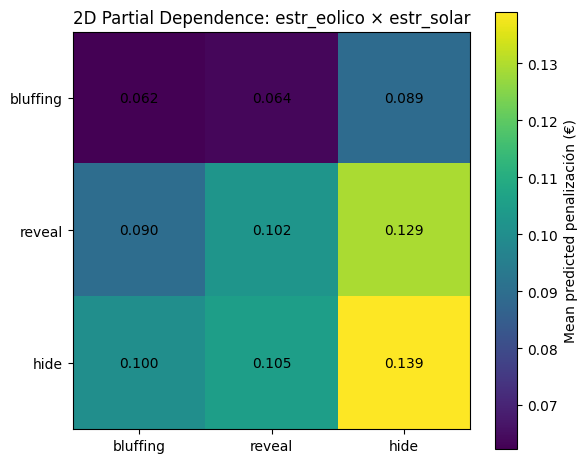

In [21]:
# 4. Heatmap
plt.figure(figsize=(6,5))
plt.imshow(heat, origin='upper')
plt.xticks(ticks=np.arange(len(eolic_strats)), labels=eolic_strats)
plt.yticks(ticks=np.arange(len(solar_strats)), labels=solar_strats)
plt.colorbar(label='Mean predicted penalización (€)')
plt.title('2D Partial Dependence: estr_eolico × estr_solar')
# annotate cells
for i in range(len(solar_strats)):
    for j in range(len(eolic_strats)):
        plt.text(j, i, f"{heat[i,j]:.3f}", ha='center', va='center', color='black')
plt.tight_layout()


|                    | eólico bluffing | eólico reveal | eólico hide |
| ------------------ | :-------------: | :-----------: | :---------: |
| **solar bluffing** |   **0.062 €**   |    0.064 €    |   0.089 €   |
| **solar reveal**   |     0.090 €     |    0.102 €    |   0.129 €   |
| **solar hide**     |     0.100 €     |    0.105 €    | **0.139 €** |


Más oscuro = coste menor; más claro = coste mayor.

Lectura rápida
Mejor combinación (mínimo coste) → Solar bluffing + Eólico bluffing (0.062 €).

Peor combinación (máximo coste) → Solar hide + Eólico hide (0.139 €).

Impacto asimétrico

Si el eólico pasa de bluffing a hide, el coste sube entre +0.027 € y +0.039 € según lo que haga el solar.

Cambiar el solar de bluffing a hide añade +0.038 € a +0.050 €, pero la penalización base es ya más baja si el eólico sigue en bluffing.

Implicaciones
Evitar “hide/hide” es crítico (duplica la penalización frente al óptimo).

Bluffing solar cubre huecos incluso si el eólico está en reveal, pero pierde buena parte del beneficio si el eólico es hide.

Reveal en ambos agentes es neutro intermedio; ningún incentivo extra salvo la transparencia.

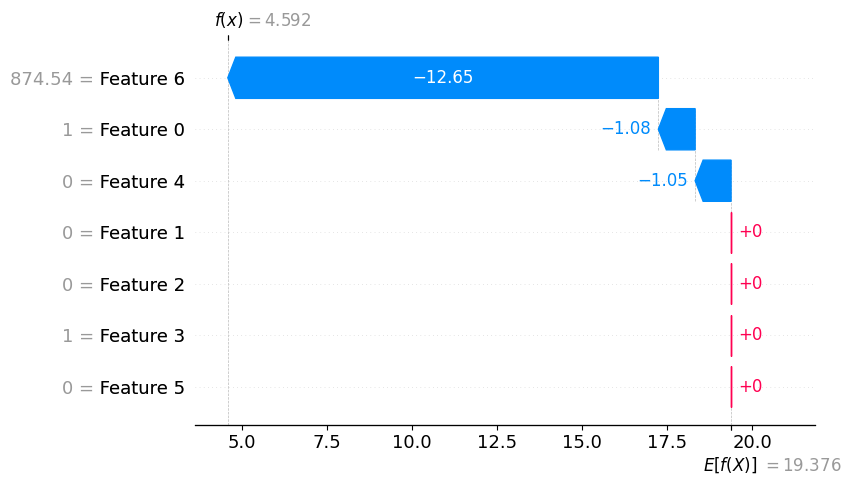

In [ ]:
# Creamos el explainer compatible con tree-based models
explainer = shap.Explainer(pipe.named_steps['model'])

# Aplicamos la transformación previa al dataset
X_transformed = pipe.named_steps['pre'].transform(X)

# Calculamos los valores SHAP
shap_values = explainer(X_transformed)

# Visualizamos la explicación de una predicción individual (por ejemplo, la número 0)
shap.plots.waterfall(shap_values[0])
# Obtener nombres de columnas transformadas
feature_names = pipe.named_steps['pre'].get_feature_names_out()
# Asignar nombres al SHAP values
shap_values.data = pd.DataFrame(X_transformed, columns=feature_names)

